## Week 12 Workshop

In this week we are continuing to work with the multi-modal model ESM-3, which can do a variety of protein design tasks. We will also use AlphaFold 3 to predict structures.

This workshop notebook contains material from the ESM-3 tutorials, specifically [Tutorial 1](https://github.com/evolutionaryscale/esm/blob/main/cookbook/tutorials/1_esmprotein.ipynb) and [Tutorial 3.](https://github.com/evolutionaryscale/esm/blob/main/cookbook/tutorials/3_gfp_design.ipynb)
 
To work through all the elements of this workshop, you will need free accounts on both the ESM Forge and the AlphaFold Server:

- ESM Forge: https://forge.evolutionaryscale.ai/
- AlphaFold Server: https://alphafoldserver.com/

As always, we start by importing the dependencies.

In [ ]:
#import esm
#from esm.sdk.api import ESMProtein, GenerationConfig
#import py3Dmol
#import biotite.structure.io.pdbx as pdbx
#from biotite.structure.io.pdb import PDBFile
#from biotite.structure import superimpose, rmsd
#from io import StringIO
#import warnings
#

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps

import torch

import biotite.sequence as seq
import biotite.sequence.align as align
import biotite.sequence.graphics as graphics
from biotite.database import rcsb

import esm
from esm.sdk.api import ESMProtein, GenerationConfig
from esm.utils.structure.protein_chain import ProteinChain

import py3Dmol
from getpass import getpass


## The different tracks of ESM-3



In [12]:
pdb_id = "1cm4"
chain_id = "A"

# download pdb file from RCSB
str_io = rcsb.fetch(pdb_id, "pdb")
# generate a ProteinChain object (holds the protein structure)
protein_chain = ProteinChain.from_pdb(str_io, chain_id=chain_id, id=pdb_id)
# generate an ESMProtein object (used as input for ESM-3)
protein = ESMProtein.from_protein_chain(protein_chain)


In [13]:
print(protein.sequence)
print(protein.coordinates)

LTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTEAELQDMINEVDADGNGTIDFPEFLTMMARKMKDTDSEEEIREAFRVFDKDGNGYISAAELRHVMTNLGEKLTDEEVDEMIREADIDGDGQVNYEEFVQMMT
tensor([[[29.4900, 55.2300, 89.4950],
         [28.5830, 56.0660, 88.7360],
         [28.2720, 57.3360, 89.5170],
         ...,
         [    nan,     nan,     nan],
         [    nan,     nan,     nan],
         [    nan,     nan,     nan]],

        [[27.5510, 58.2640, 88.8800],
         [27.1540, 59.5320, 89.4890],
         [25.6850, 59.8650, 89.2390],
         ...,
         [    nan,     nan,     nan],
         [    nan,     nan,     nan],
         [    nan,     nan,     nan]],

        [[25.1770, 60.9740, 89.8140],
         [23.7800, 61.4010, 89.6760],
         [23.3690, 61.5970, 88.2230],
         ...,
         [    nan,     nan,     nan],
         [    nan,     nan,     nan],
         [    nan,     nan,     nan]],

        ...,

        [[30.1690, 65.5070, 73.3640],
         [29.0820, 65.4730, 74.3330],
         [28.9170, 64.0580, 74.881

In [ ]:
# Functions for visualizing 3D structure
def visualize_pdb(pdb_string):
    view = py3Dmol.view(width=400, height=400)
    view.addModel(pdb_string, "pdb")
    view.setStyle({"cartoon": {"color": "spectrum"}})
    view.zoomTo()
    view.render()
    view.center()
    return view


In [9]:
# visualize from sequence and coordinates
visualize_pdb(protein.to_pdb_string())

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [10]:
from biotite.structure import annotate_sse

def get_approximate_ss(protein_chain: ProteinChain):
    # get biotite's ss3 representation
    ss3_arr = annotate_sse(protein_chain.atom_array)
    biotite_ss3_str = "".join(ss3_arr)

    # translate into ESM3's representation
    translation_table = str.maketrans(
        {
            "a": "H",  # alpha helix
            "b": "E",  # beta sheet
            "c": "C",  # coil
        }
    )
    esm_ss3 = biotite_ss3_str.translate(translation_table)
    return esm_ss3

In [14]:
print(protein.secondary_structure)
protein.secondary_structure = get_approximate_ss(protein_chain)
print(protein.secondary_structure)

None
CCHHHHHHHHHHHHHHCCCCCCCCCHHHHHHHHHHHCCCCCHHHHHHCCCCCCCCCCCCCCHHHHHHHHHEEEEECCCCCHHHHHHHHHHCCCCCCCCHHHHHHHHHHHCCCCCHHHHHHHHHHHCCCCCCCCCHHHHHHHHC


Solvent accessibilities (in Angstrom squared)

In [15]:
protein.sasa = protein_chain.sasa()
print(protein.sasa)

[113.9064126   66.84046347 151.58566976 110.22579587  65.21257734
  67.05624759  37.75985886 104.09553798  28.61006296 111.43817843
  96.7437793   32.69667646  17.22026888  66.13807178  42.86836755
  46.42861262  18.02085274 107.30399188 109.57204048  33.6287334
 102.48682278  40.30218506  25.63876426   2.29829866  36.01073039
  30.20481248 154.88023098  18.05886418  19.46794286   0.4055821
  66.99336678   9.19319528  38.87457792 112.76914182  55.49316573
  73.86329079  74.25680101 115.915171   126.4028534   24.41808629
  72.50270122 141.19612706  56.56407779 102.59139559  16.22328517
  81.91708083  89.16244023  79.9549429    9.46358287  81.54411298
 107.39107668  29.07180178  13.81817412  70.88019848 113.52661872
  42.83203323 103.6916638   42.10752678  25.24274802   6.62450838
  48.66805437  52.51189262  86.73720896  17.24917915  11.82451096
  48.64645213  76.11676431  57.03970399  47.44737966  58.34539403
 204.67658627 137.77966642 134.92414206  63.79012585 107.32675076
 124.4019727

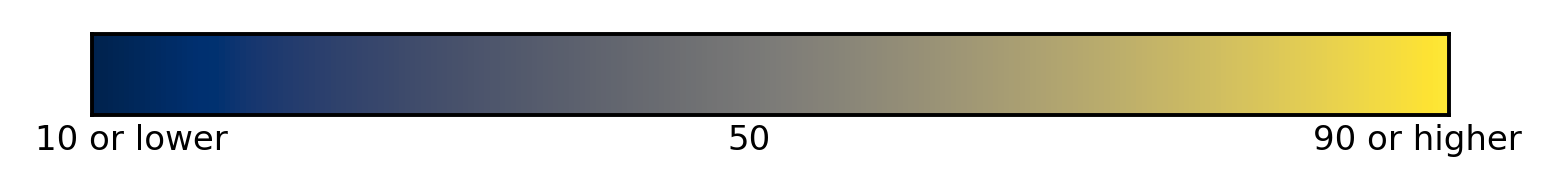

In [ ]:
cmap = colormaps["cividis"]
clip_sasa_lower = 10
clip_sasa_upper = 90


def plot_heatmap_legend(cmap, clip_sasa_lower, clip_sasa_upper):
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    _, ax = plt.subplots(figsize=(5, 0.3), dpi=350)
    ax.imshow(gradient, aspect="auto", cmap=cmap)
    ax.text(
        0.1,
        -0.3,
        f"{clip_sasa_lower} or lower",
        va="center",
        ha="right",
        fontsize=7,
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.3,
        f"{(clip_sasa_lower + clip_sasa_upper) // 2}",
        va="center",
        ha="right",
        fontsize=7,
        transform=ax.transAxes,
    )
    ax.text(
        0.9,
        -0.3,
        f"{clip_sasa_upper} or higher",
        va="center",
        ha="left",
        fontsize=7,
        transform=ax.transAxes,
    )
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

# Functions for visualizing SASA as colors on the 3D structure
def get_color_strings(sasa, clip_sasa_lower, clip_sasa_upper, cmap):
    transformed_sasa = np.clip(sasa, clip_sasa_lower, clip_sasa_upper)
    transformed_sasa = (transformed_sasa - clip_sasa_lower) / (
        clip_sasa_upper - clip_sasa_lower
    )
    rgbas = (cmap(transformed_sasa) * 255).astype(int)

    return [f"rgb({rgba[0]},{rgba[1]},{rgba[2]})" for rgba in rgbas]


def visualize_sasa_3D_protein(
    protein, clip_sasa_lower=clip_sasa_lower, clip_sasa_upper=clip_sasa_upper, cmap=cmap
):
    pdb_string = protein.to_pdb_string()
    plot_heatmap_legend(cmap, clip_sasa_lower, clip_sasa_upper)
    view = py3Dmol.view(width=400, height=400)
    view.addModel(pdb_string, "pdb")

    for res_pos, res_color in enumerate(
        get_color_strings(protein.sasa, clip_sasa_lower, clip_sasa_upper, cmap)
    ):
        view.setStyle(
            {"chain": "A", "resi": res_pos + 1}, {"cartoon": {"color": res_color}}
        )
    view.zoomTo()
    view.render()
    view.center()

    return view

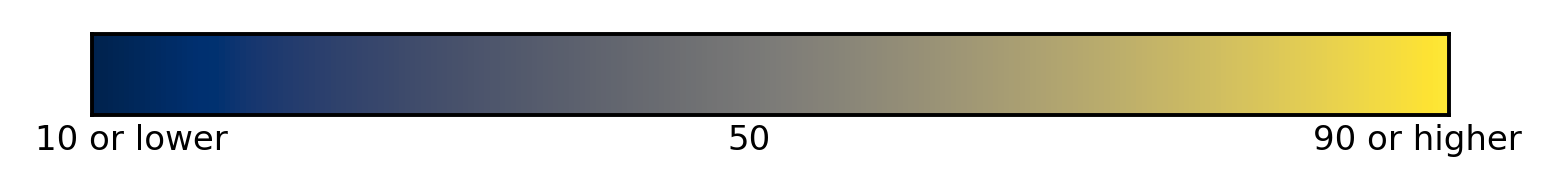

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [19]:
visualize_sasa_3D_protein(protein)

We have skipped over functional annotations here. Go over the [full tutorial on this topic](https://github.com/evolutionaryscale/esm/blob/main/cookbook/tutorials/1_esmprotein.ipynb) to learn about this remaining track.

## Design a new fluorescent protein

The actual protein design will use the ESM Forge, as in the previous week.

The ESM Forge uses an API Key system through which you can interact from your Python scripts with their server. To generate a key, log in to your account, click on "API Keys" and create a new key. Save the key in a secure location. It is like a password.

In [22]:
# Enter your API key here. Remeber you need to keep it confidential.
# Never add your key to a github repo or post it publicly in any way.
api_key = getpass("Your EvolutionaryScale API key: ")

Now we can create the model object. Unlike in previous workshops, we are not downloading the model, we are simply connecting to the ESM Forge server.

In [25]:
model = esm.sdk.client("esm3-medium-2024-08", token=api_key)

Generate the prompt.

In [26]:
template_gfp = ESMProtein.from_protein_chain(
    ProteinChain.from_rcsb("1qy3", chain_id="A")
)
template_gfp_tokens = model.encode(template_gfp)

print("Sequence tokens:")
print(
    "    ", ", ".join([str(token) for token in template_gfp_tokens.sequence.tolist()])
)

print("Structure tokens:")
print(
    "    ", ", ".join([str(token) for token in template_gfp_tokens.structure.tolist()])
)

Sequence tokens:
     0, 15, 6, 9, 9, 4, 18, 11, 6, 7, 7, 14, 12, 4, 7, 9, 4, 13, 6, 13, 7, 17, 6, 21, 15, 18, 8, 7, 8, 6, 9, 6, 9, 6, 13, 5, 11, 19, 6, 15, 4, 11, 4, 15, 18, 12, 23, 11, 11, 6, 15, 4, 14, 7, 14, 22, 14, 11, 4, 7, 11, 11, 4, 11, 19, 6, 7, 16, 23, 18, 8, 10, 19, 14, 13, 21, 20, 15, 16, 21, 13, 18, 18, 15, 8, 5, 20, 14, 9, 6, 19, 7, 16, 9, 5, 11, 12, 8, 18, 15, 13, 13, 6, 17, 19, 15, 11, 10, 5, 9, 7, 15, 18, 9, 6, 13, 11, 4, 7, 17, 10, 12, 9, 4, 15, 6, 12, 13, 18, 15, 9, 13, 6, 17, 12, 4, 6, 21, 15, 4, 9, 19, 17, 19, 17, 8, 21, 17, 7, 19, 12, 11, 5, 13, 15, 16, 15, 17, 6, 12, 15, 5, 17, 18, 15, 12, 10, 21, 17, 12, 9, 13, 6, 8, 7, 16, 4, 5, 13, 21, 19, 16, 16, 17, 11, 14, 12, 6, 13, 6, 14, 7, 4, 4, 14, 13, 17, 21, 19, 4, 8, 11, 16, 8, 5, 4, 8, 15, 13, 14, 17, 9, 15, 10, 13, 21, 20, 7, 4, 4, 9, 18, 7, 11, 5, 5, 6, 12, 2
Structure tokens:
     4098, 1025, 3124, 1129, 3227, 722, 1645, 2037, 2490, 60, 2567, 1779, 457, 2708, 383, 2219, 653, 4084, 2984, 3370, 66, 608, 2504, 103,

From tutorial:

> We'll now build a prompt. Specifically we'll specify 4 amino acid identities at positions near where we want the chromophore to form, and 2 amino acid identities on the beta barrel that are known to support chromophore formation.
>
> Furthermore we'll specify the structure should be similar to the 1qy3 structure at all these positions by adding tokens from the encoded 1qy3 structure to the structure track of our prompt. We'll also specify a few more positions (along the alpha helix kink).

In [27]:
prompt_sequence = ["_"] * len(template_gfp.sequence)
prompt_sequence[59] = "T"
prompt_sequence[62] = "T"
prompt_sequence[63] = "Y"
prompt_sequence[64] = "G"
prompt_sequence[93] = "R"
prompt_sequence[219] = "E"
prompt_sequence = "".join(prompt_sequence)

print(template_gfp.sequence)
print(prompt_sequence)

prompt = model.encode(ESMProtein(sequence=prompt_sequence))

# We construct an empty structure track like |<bos> <mask> ... <mask> <eos>|...
prompt.structure = torch.full_like(prompt.sequence, 4096)
prompt.structure[0] = 4098
prompt.structure[-1] = 4097
# ... and then we fill in structure tokens at key residues near the alpha helix
# kink and at the stabilizing R and E positions on the beta barrel.
prompt.structure[55:70] = template_gfp_tokens.structure[56:71]
prompt.structure[93] = template_gfp_tokens.structure[93]
prompt.structure[219] = template_gfp_tokens.structure[219]

print("".join(["✔" if st < 4096 else "_" for st in prompt.structure]))

KGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQEATISFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYITADKQKNGIKANFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGI
___________________________________________________________T__TYG____________________________R_____________________________________________________________________________________________________________________________E_______
_______________________________________________________✔✔✔✔✔✔✔✔✔✔✔✔✔✔✔_______________________✔_____________________________________________________________________________________________________________________________✔_________


From tutorial:
> The output shows the original 1qy3 sequence and the our prompt sequence track amino acid identities and the positions that have a token on the structure track. ESM3 will then be tasked with filling in the structure and sequence at the remaining masked (underscore) positions.
>
> One small note, we introduced the mutation A93R in our prompt. This isn't a mistake. Using Alanine at this position causes the chromophore to mature extremely slowly (which is how we are able to measure the precyclized structure of GFP!). However we don't want to wait around for our GFPs to glow so we go with Arginine at this position.

In [34]:
num_tokens_to_decode = min((prompt.structure == 4096).sum().item(), 20)

structure_generation = model.generate(
    prompt,
    GenerationConfig(
        # Generate a structure.
        track="structure",
        # Sample one token per forward pass of the model.
        num_steps=num_tokens_to_decode,
        # Sampling temperature trades perplexity with diversity.
        temperature=1.0,
    ),
)

print("These are the structure tokens corresponding to our new design:")
print(
    "    ", ", ".join([str(token) for token in structure_generation.structure.tolist()])
)

# Decodes structure tokens to backbone coordinates.
structure_generation_protein = model.decode(structure_generation)

These are the structure tokens corresponding to our new design:
     4098, 3235, 760, 155, 2699, 2498, 2747, 16, 16, 2747, 137, 3405, 2720, 2279, 1035, 3391, 3462, 598, 744, 30, 1626, 1902, 867, 2159, 3018, 2121, 867, 136, 3728, 2279, 2585, 50, 2498, 2747, 50, 3207, 598, 2747, 287, 2516, 598, 1154, 1035, 1972, 2516, 3310, 2680, 363, 646, 3831, 3978, 4046, 3605, 2747, 192, 1774, 732, 1797, 3372, 3403, 2370, 2582, 3704, 2737, 3007, 1660, 499, 484, 2202, 2786, 3012, 2131, 597, 1179, 232, 3148, 216, 1637, 882, 1484, 1921, 321, 1265, 1552, 3115, 3932, 1739, 1640, 2791, 1974, 1326, 301, 1443, 1066, 3552, 1272, 2804, 1083, 404, 276, 1546, 3989, 3334, 4086, 3840, 3312, 2641, 497, 2609, 3041, 3189, 404, 1501, 3106, 1632, 1884, 665, 3350, 2871, 2016, 1158, 3128, 3972, 3662, 3721, 2925, 1434, 3166, 3949, 303, 2405, 2440, 318, 3692, 1126, 387, 1272, 622, 1143, 3619, 3166, 1191, 2447, 121, 252, 1872, 2454, 3257, 1523, 3469, 1158, 1189, 3164, 3445, 167, 708, 437, 712, 3356, 2394, 2488, 2980, 3818, 3

In [35]:
view = py3Dmol.view(width=1000, height=500)
view.addModel(
    structure_generation_protein.to_protein_chain().infer_oxygen().to_pdb_string(),
    "pdb",
)
view.setStyle({"cartoon": {"color": "lightgreen"}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

> At this point we only want to continue the generation if this design is a close match to a wildtype GFP at the active site, has some structural difference across the full protein (otherwise it would end up being very sequence-similar to wildtype GFP), and overall still looks like the classic GFP alpha helix in a beta barrel structure.
> 
> Of course when generating many designs we cannot look at each one manually, so we adopt some automated rejection sampling criteria based on the overall structure RMSD and the constrained site RMSD for our generated structure being faithful to the prompt. If these checks pass then we'll try to design a sequence for this structure. If not, one should go back up a few cells and design another structure until it passes these computational screens. (Or not... this is your GFP design!)

In [36]:
constrained_site_positions = [59, 62, 63, 64, 93, 219]

template_chain = template_gfp.to_protein_chain()
generation_chain = structure_generation_protein.to_protein_chain()

constrained_site_rmsd = template_chain[constrained_site_positions].rmsd(
    generation_chain[constrained_site_positions]
)
backbone_rmsd = template_chain.rmsd(generation_chain)

c_pass = "✅" if constrained_site_rmsd < 1.5 else "❌"
b_pass = "✅" if backbone_rmsd > 1.5 else "❌"

print(f"Constrained site RMSD: {constrained_site_rmsd:.2f} Ang {c_pass}")
print(f"Backbone RMSD: {backbone_rmsd:.2f} Ang {b_pass}")

Constrained site RMSD: 3.46 Ang ❌
Backbone RMSD: 11.06 Ang ✅


Now we generate a sequence onto that structure. (For this tutorial, need to copy the structure from GFP, as generation will likely not work.)

In [37]:
# Based on internal research, there's not a benefit to iterative decoding past 20 steps
num_tokens_to_decode = min((prompt.sequence == 32).sum().item(), 20)

sequence_generation = model.generate(
    # Generate a sequence.
    structure_generation,
    GenerationConfig(track="sequence", num_steps=num_tokens_to_decode, temperature=1.0),
)

# Refold
sequence_generation.structure = None
length_of_sequence = sequence_generation.sequence.numel() - 2
sequence_generation = model.generate(
    sequence_generation,
    GenerationConfig(track="structure", num_steps=1, temperature=0.0),
)

# Decode to AA string and coordinates.
sequence_generation_protein = model.decode(sequence_generation)

In [38]:

sequence_generation_protein.sequence

'MQQQQQQQQQQQQQQQQQARQQQQQQQQEQQQEQQERQQQGQLERDGQPDRQQQVERRLTELTYGLAGVTELRVASNSVHPEGGEPLYFVGAEREEGRLVVAFGRNGEVVLTFEYTREGDTLRVTQVHTRPDGSRESVSTDIPFTGFEGDSGKQTVEYEELVPDDATPEQEALGGTGRHPVEVVIEFVEPGVIRFTYTVYTGEVVDGVLQKEVLTTVVLEYTFGKPK'

Make alignment to original sequence

Sequence identity: 15.60%

Sequence alignment:


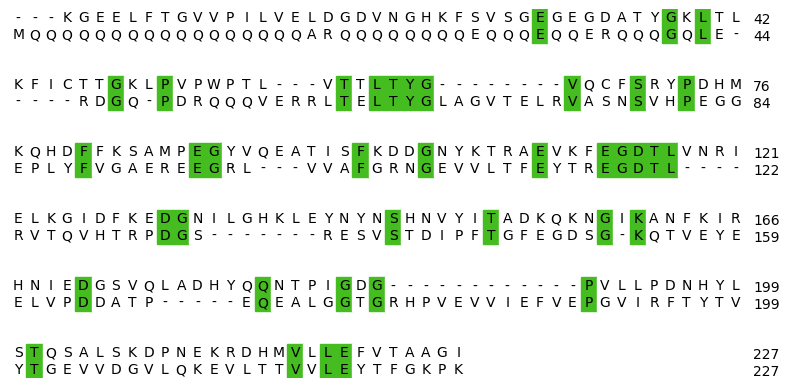

In [40]:
seq1 = seq.ProteinSequence(template_gfp.sequence)
seq2 = seq.ProteinSequence(sequence_generation_protein.sequence)

alignments = align.align_optimal(
    seq1, seq2, align.SubstitutionMatrix.std_protein_matrix(), gap_penalty=(-10, -1)
)

alignment = alignments[0]

identity = align.get_sequence_identity(alignment)
print(f"Sequence identity: {100*identity:.2f}%")

print("\nSequence alignment:")
fig = plt.figure(figsize=(8.0, 4.0))
ax = fig.add_subplot(111)
graphics.plot_alignment_similarity_based(
    ax, alignment, symbols_per_line=45, spacing=2, show_numbers=True
)
fig.tight_layout()
plt.show()

> We now recheck our computational metrics for the constrained site. If we see the constrained site is not a match then we'd want to try designing the sequence again. If many attempts to design a sequence that matches the structure fail, then it's likely the structure is not easily designable and we may want to reject this structure generation as well!
>
> At this point the backbone RMSD doesn't matter very much to us, so long as the sequence is adequately distant to satisfy our scientific curiosity!

In [41]:
template_chain = template_gfp.to_protein_chain()
generation_chain = sequence_generation_protein.to_protein_chain()

constrained_site_rmsd = template_chain[constrained_site_positions].rmsd(
    generation_chain[constrained_site_positions]
)
backbone_rmsd = template_chain.rmsd(generation_chain)

c_pass = "✅" if constrained_site_rmsd < 1.5 else "❌"
b_pass = "🤷‍♂️"

print(f"Constrained site RMSD: {constrained_site_rmsd:.2f} Ang {c_pass}")
print(f"Backbone RMSD: {backbone_rmsd:.2f} Ang {b_pass}")

Constrained site RMSD: 3.12 Ang ❌
Backbone RMSD: 17.10 Ang 🤷‍♂️


In [42]:
view = py3Dmol.view(width=600, height=600)
view.addModel(sequence_generation_protein.to_pdb_string(), "pdb")
view.setStyle({"cartoon": {"color": "lightgreen"}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Exercises

- Compare the structure produced by ESM-3 for the designed sequence to the structure AlphaFold predicts for the same sequence.

-

-